# 3. Methodology section:
This section represents the main component of the report where the data is gathered, prepared for analysis. The tools described are used here and the Notebook cells indicates the execution of steps.

## The analysis and the stragegy:
The strategy is based on mapping the above described data in section 2.0, in order to facilitate the choice of at least two candidate places for rent. The choice is made based on the demands imposed : location near a subway, rental price and similar venues to Singapore. This visual approach and maps with popups labels allow quick identification of location, price and feature, thus making the selection very easy.

The procesing of these DATA and its mapping will allow to answer the key questions to make a decision:

* what is the cost of available rental places that meet the demands?
* what is the cost of rent around a mile radius from each subway metro station?
* what is the area of Manhattan with best rental pricing that meets criteria established?
* What is the distance from work place ( Park Ave and 53 rd St) and the tentative future rental home?
* What are the venues of the two best places to live? How the prices compare?
* How venues distribute among Manhattan neighborhoods and around metro stations?
* Are there tradeoffs between size and price and location?
* Any other interesting statistical data findings of the real estate and overall data.

# METHODOLOY EXECUTION - Mapping Data

## India-hyderabad Map - Current residence and venues in neighborhood
### for comparison to future Manhattan renting place

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

In [3]:
# current residing address and get lat and lng data
address = 'Jubilee Hills, Hyderabad,India'
geolocator = Nominatim(user_agent = "py_user")
location = geolocator.geocode(address)
hyd_lat = location.latitude
hyd_lng = location.longitude

print("The geolographical coordiantes of home in hyderabad are :", hyd_lat, hyd_lng)

The geolographical coordiantes of home in hyderabad are : 17.4308362 78.4102882


### Dial FourSquare to find venues around current residence in hyderabad,India 

In [4]:
# foursquare credentials
client_id = 'HVAQAPQ5SWPJG1NF5UVA0O0XGBTPEVXHVTQYFJQQ5Z4CV3VQ'
client_secret = 'KXU1T5NEUFFACVT0GSLMWBBMLX1ZRMOQNP1VTRJ05AT1BMDA'
version = '20200605'
limit = 100
radius = 500

# build up url
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    client_id, 
    client_secret, 
    version, 
    hyd_lat, 
    hyd_lng, 
    radius, 
    limit)

url # display url

'https://api.foursquare.com/v2/venues/search?&client_id=HVAQAPQ5SWPJG1NF5UVA0O0XGBTPEVXHVTQYFJQQ5Z4CV3VQ&client_secret=KXU1T5NEUFFACVT0GSLMWBBMLX1ZRMOQNP1VTRJ05AT1BMDA&v=20200605&ll=17.4308362,78.4102882&radius=500&limit=100'

In [5]:
#results commented for report simlification

results = requests.get(url).json()
#results

### function that extracts the category of the venue - borrow from the Foursquare lab.

In [6]:
#function to get the categories
#get all the venues from the json structure and normalise to a df
 
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['venues']#[0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
hyd_nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
hyd_nearby_venues['categories'] = hyd_nearby_venues.apply(get_category_type, axis=1)

# clean columns
hyd_nearby_venues.columns = [col.split(".")[-1] for col in hyd_nearby_venues.columns]

# print the venues in hyderabad
hyd_nearby_venues.head(10)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng
0,air live,Lounge,17.430168,78.410336
1,Chutneys,Indian Restaurant,17.429835,78.409657
2,nandagiri hills,Scenic Lookout,17.425433,78.408753
3,Apsara Ice Creams,Ice Cream Shop,17.429960,78.410900
4,McDonald's,Fast Food Restaurant,17.430490,78.408960
5,Y-Axis Jubilee Hills,Embassy / Consulate,17.430105,78.409790
6,KBR Park,Park,17.425369,78.425063
7,Club N,Nightclub,17.429360,78.410790
8,Tatva Legal,Office,17.430814,78.410373
9,Van Lavino,Deli / Bodega,17.429620,78.410144


### Map of Hyderabad's residence place with venues in Neighborhood - for reference

In [7]:
# check out the map of jubilee hills hyderabad

hyd_map = folium.Map(location = [hyd_lat, hyd_lng], zoom_start = 17)

#adding markers to the map
for lat,lng,name in zip(hyd_nearby_venues['lat'],hyd_nearby_venues['lng'],hyd_nearby_venues['name']):
    hood = '{}'.format(name)
    label = folium.Popup(hood,parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius = 5,
    popup = label,
    color = 'blue',
    fill_color = '3186cc',
    fill_opacity = 0.6,
    ).add_to(hyd_map)
    
hyd_map

# MANHATTAN NEIGHBORHOODS - DATA AND MAPPING
### Cluster neighborhood data was produced with Foursquare . similar to hyd get the venues data for manhattan , cluster it and get the top 10 venues list into a data frame .This is executed in 10 steps .

In [8]:
# get the new york data set and obtain the mahattan data

with open('nyu_data.json') as json_data:
    newy_data = json.load(json_data)
newyork_data = newy_data['features']
newyork_data 

column_names = ['borough','neighbourhood','lat','lng']
nyu_df = pd.DataFrame(columns = column_names)
nyu_df

for data in newyork_data:
    borough = name = data['properties']['borough']
    name = data['properties']['name']
    location = data['geometry']['coordinates']
    lat = location[1]
    lng = location[0]
    nyu_df = nyu_df.append({'borough' : borough,
                 'neighbourhood' : name,
                 'lat' : lat,
                 'lng' : lng },ignore_index = True)
nyu_df

manhattan_df = nyu_df[nyu_df['borough'] == 'Manhattan'].reset_index(drop = True)
manhattan_df.head()

,borough,neighbourhood,lat,lng
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### Step:1 get the coordinates of manhattan and also obtain manhattan data

In [9]:
address = 'manhattan, NY'
geolocator = Nominatim(user_agent = 'py_user')
location = geolocator.geocode(address)
man_lat = location.latitude
man_lng = location.longitude
print("The coordinates for manhattan are :" , man_lat,man_lng)


The coordinates for manhattan are : 40.7896239 -73.9598939


### Step:2 build url 

In [10]:

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    client_id, 
    client_secret, 
    version, 
    man_lat, 
    man_lng, 
    radius, 
    limit)

url # display url

'https://api.foursquare.com/v2/venues/search?&client_id=HVAQAPQ5SWPJG1NF5UVA0O0XGBTPEVXHVTQYFJQQ5Z4CV3VQ&client_secret=KXU1T5NEUFFACVT0GSLMWBBMLX1ZRMOQNP1VTRJ05AT1BMDA&v=20200605&ll=40.7896239,-73.9598939&radius=500&limit=100'

### Step:3 get the manhattan venues and clean the data and get desired columns data and split at '.'

In [11]:
 
manhattan_venues = requests.get(url,timeout = 5000 ).json()
#manhattan_venues

venues = manhattan_venues['response']['venues'] #[0]['items']
manhattan_venues = json_normalize(venues)

# get desired columns
filtered_columns = ['name','categories','location.lat','location.lng']
manhattan_nearby_venues = manhattan_venues.loc[:,filtered_columns]

manhattan_nearby_venues['categories'] = manhattan_nearby_venues.apply(get_category_type, axis=1)

# split at '.'
manhattan_nearby_venues.columns = [col.split(".")[-1] for col in manhattan_nearby_venues.columns]
manhattan_nearby_venues.head()


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,name,categories,lat,lng
0,Jacqueline Kennedy Onassis Reservoir,Reservoir,40.785064,-73.960163
1,Central Park - North Meadow Recreation Center,Playground,40.790939,-73.960304
2,Central Park - 97th St Transverse,Outdoors & Recreation,40.788515,-73.955104
3,Key Food Fresh of Amsterdam Avenue,Grocery Store,40.794466,-73.969807
4,Oldest Tree in Central Park,Park,40.789188,-73.957867


### Step:4 explore all the neighbourhood venues of manhattan

In [12]:
 
# create a function

# explore all the neighbourhoods in North York

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url,timeout = 5000).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# execute the above function and get manhattan neighbourhood venues

man_neigh_data = getNearbyVenues(names=manhattan_df['neighbourhood'],
                                   latitudes=manhattan_df['lat'],
                                   longitudes=manhattan_df['lng']
                                  )
#man_neigh_data

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


### Step:5 Let's check the size of the resulting dataframe

In [13]:

print(man_neigh_data.shape)
man_neigh_data.head()

#Let's check how many venues were returned for each neighborhood
man_neigh_data.groupby('Neighbourhood').count()

(3194, 7)


,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Battery Park City,66,66,66,66,66,66
Carnegie Hill,97,97,97,97,97,97
Central Harlem,46,46,46,46,46,46
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,41,41,41,41,41,41
East Village,100,100,100,100,100,100


### Step:6 Analyze Each Neighborhood

In [14]:


# one hot encoding
manhattan_onehot = pd.get_dummies(man_neigh_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighbourhood'] = man_neigh_data['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soba Re

### Step:7 Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [15]:

manhattan_grouped = manhattan_onehot.groupby('Neighbourhood').mean().reset_index()
manhattan_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soba Re

### Step:8 Let's print each neighborhood along with the top 5 most common venues

In [16]:

num_top_venues = 5

for hood in manhattan_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighbourhood'] == hood].T.reset_index()
    
    temp.columns = ['venue','freq']
    
    temp = temp.iloc[1:]
    
    temp['freq'] = temp['freq'].astype(float)
    
    temp = temp.round({'freq': 2})
    
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.09
1          Hotel  0.08
2    Coffee Shop  0.06
3            Gym  0.06
4  Memorial Site  0.05


----Carnegie Hill----
                  venue  freq
0           Coffee Shop  0.07
1                  Café  0.04
2           Pizza Place  0.04
3                   Bar  0.04
4  Gym / Fitness Center  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1                  Bar  0.04
2   Chinese Restaurant  0.04
3  American Restaurant  0.04
4    French Restaurant  0.04


----Chelsea----
                 venue  freq
0          Coffee Shop  0.09
1          Art Gallery  0.05
2               Bakery  0.04
3    French Restaurant  0.03
4  American Restaurant  0.03


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.10
1           Cocktail Bar  0.05
2                 Bakery  0.05
3           Optical Shop  0.03
4  Vietnamese Restaurant  0.03


----Civic Center----
            

### Step:9 First, let's write a function to sort the venues in descending order

In [17]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = manhattan_grouped['Neighbourhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Gym,Memorial Site,Playground,Boat or Ferry,Food Court,Plaza,Gourmet Shop
1,Carnegie Hill,Coffee Shop,Pizza Place,Café,Bar,Bakery,Gym / Fitness Center,Gym,Italian Restaurant,French Restaurant,Bookstore
2,Central Harlem,African Restaurant,Seafood Restaurant,American Restaurant,Bar,Cosmetics Shop,French Restaurant,Chinese Restaurant,Indie Theater,Library,Bookstore
3,Chelsea,Coffee Shop,Art Gallery,Bakery,French Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Pizza Place,Hotel,Bar
4,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,Ice Cream Shop,Dessert Shop,Spa,Bubble Tea Shop,American Restaurant,Optical Shop,Vietnamese Restaurant


### Step:10 Cluster Neighborhoods

In [18]:

#Run k-means to cluster the neighborhood into 5 clusters

# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

#2.Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='neighbourhood')



# Manhattan Borough neighborhoods - data with top 10 clustered venues

# 

In [24]:
manhattan_merged.to_csv("manhattan_merged.csv")

manhattan_merged.head()


,borough,neighbourhood,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Gym,Coffee Shop,Seafood Restaurant,Tennis Stadium,Big Box Store,Supplement Shop,Steakhouse,Miscellaneous Shop,Shopping Mall,Yoga Studio
1,Manhattan,Chinatown,40.715618,-73.994279,4,Chinese Restaurant,Cocktail Bar,Bakery,Ice Cream Shop,Dessert Shop,Spa,Bubble Tea Shop,American Restaurant,Optical Shop,Vietnamese Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Deli / Bodega,Chinese Restaurant,Mobile Phone Shop,Grocery Store,Tapas Restaurant,Coffee Shop,Spanish Restaurant,Park
3,Manhattan,Inwood,40.867684,-73.921210,4,Mexican Restaurant,Lounge,Café,Restaurant,Caribbean Restaurant,Deli / Bodega,Pizza Place,Wine Bar,American Restaurant,Park
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Yoga Studio,Bakery,Cocktail Bar,Sandwich Place,School


# Map of Manhattan neighborhoods with top 10 clustered venues
### popus allow to identify each neighborhood and the cluster of venues around it in order to proceed to examine in more detail in the next cell

In [19]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558 

kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['lat'], manhattan_merged['lng'], manhattan_merged['neighbourhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

# Examine a paticular Cluster - print venues
### After examining several cluster data , I concluded that cluster # 2 resembles closer the Hyderabad place, therefore providing guidance as to where to look for the future apartment .
### Assign a value to 'kk' to explore a given cluster.

In [50]:
## kk is the cluster number to explore
kk = 3
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Cosmetics Shop,Burger Joint,Dessert Shop,Coffee Shop,Clothing Store,Gym / Fitness Center,Bakery


# Map of Manhattan places for rent
### Several Manhattan real estate webs were webscrapped to collect rental data, as mentioned in section 2.0 . The resut was summarized in a csv file for direct reading, in order to consolidate the proces.
### The initial data for 144 apartment did not have the latitude and longitude data (NaN) but the information was established in the following cell using an algorythm and Nominatim.

In [21]:
mh_rent = pd.read_csv('manhattan_rent.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5,3400,10000,NaN,NaN
1,East 97th Street,Upper East Side,3.57,3,2100,7500,NaN,NaN
2,West 105th Street,Upper West Side,1.89,4,2800,5300,NaN,NaN
3,CARMINE ST.,West Village,3.03,2,1650,5000,NaN,NaN
4,171 W 23RD ST.,Chelsea,3.45,2,1450,5000,NaN,NaN


In [24]:
for n in range(len(mh_rent)):
    address = mh_rent['Address'][n]
    address=(mh_rent['Address'][n]+ ' , '+' Manhattan NY ')
    geolocator = Nominatim(user_agent='py_user')
    location = geolocator.geocode(address)
    mh_rent['Lat'][n]=location.latitude 
    mh_rent['Long']= location.longitude
    
mh_rent.head(10)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5,3400,10000,40.799771,-73.997323
1,East 97th Street,Upper East Side,3.57,3,2100,7500,40.788517,-73.997323
2,West 105th Street,Upper West Side,1.89,4,2800,5300,40.799771,-73.997323
3,CARMINE ST.,West Village,3.03,2,1650,5000,40.730337,-73.997323
4,171 W 23RD ST.,Chelsea,3.45,2,1450,5000,40.744118,-73.997323
5,76 CARMINE ST.,West Village,3.56,2,1350,4800,40.729631,-73.997323
6,E 91ST,Upper East Side,3.21,2,1450,4650,40.783323,-73.997323
7,333 east 81st street,Upper East Side,1.85,3,2430,4500,40.774324,-73.997323
8,EAST 88TH STREET,Upper East Side,3.21,2,1400,4500,40.779231,-73.997323
9,East 77th Street,Upper East Side,5.00,1,900,4500,40.772969,-73.997323


### export the rent data to a csv file for extraction in the final report

In [25]:
mh_rent.to_csv('manhattan_rent_ll.csv') 

# Manhattan apartment rent price statistics
### A US 7000 Dollar per month rent is actually around the mean value - similar to Hyderabad! wow!

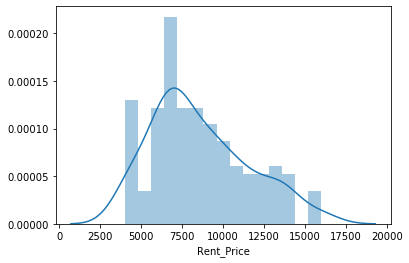

In [26]:
import seaborn as sns
sns.distplot(mh_rent['Rent_Price'],bins = 15)

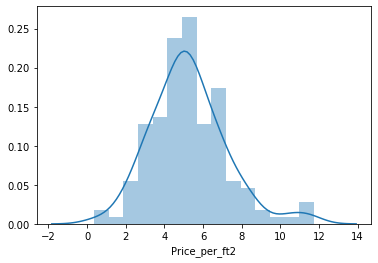

In [28]:
sns.distplot(mh_rent['Price_per_ft2'],bins = 15)

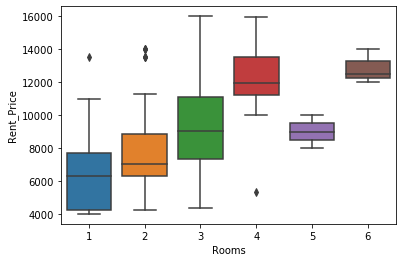

In [29]:
sns.boxplot(x= 'Rooms', y = 'Rent_Price', data = mh_rent)

# Map of Manhattan showing the places for rent and the cluster of venues
### Now, one can point to a rental place for price and address location information while knowing the cluster venues around it.
### This is an insightful way to explore rental possibilites

In [42]:
latitude= 40.7308619
longitude= -73.9871558 

kclusters=5
map_clusters = folium.Map(location=[man_lat,man_lng], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['lat'], manhattan_merged['lng'], manhattan_merged['neighbourhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

for lat,lng, address in zip(mh_rent['Lat'], mh_rent['Long'], mh_rent['Address']):
    label = folium.Popup(address, parse_html = True)
    folium.CircleMarker(
        [lat , lng],
        radius = 8,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.6).add_to(map_clusters)
        
map_clusters

# Mapping Manhattan Subway locations
### Manhattan subway metro locations ( address) was obtained from a dial to Foursqaure API


In [36]:
# @hidden_cell
client_id = 'HVAQAPQ5SWPJG1NF5UVA0O0XGBTPEVXHVTQYFJQQ5Z4CV3VQ'
client_secret = 'KXU1T5NEUFFACVT0GSLMWBBMLX1ZRMOQNP1VTRJ05AT1BMDA'
version = '20200605'
limit = 100
radius = 5000

search_query = 'subway station'

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(client_id, client_secret, man_lat, man_lng, version,search_query, radius, limit)

url

'https://api.foursquare.com/v2/venues/search?client_id=HVAQAPQ5SWPJG1NF5UVA0O0XGBTPEVXHVTQYFJQQ5Z4CV3VQ&client_secret=KXU1T5NEUFFACVT0GSLMWBBMLX1ZRMOQNP1VTRJ05AT1BMDA&ll=40.7896239,-73.9598939&v=20200605&query=subway station&radius=5000&limit=100'

In [38]:
results = requests.get(url).json()
#results

In [44]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['venues']#[0]['items']

nearby_substation = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
nearby_substation = nearby_substation.loc[:, filtered_columns]

# filter the category for each row
nearby_substation['categories'] = nearby_substation.apply(get_category_type, axis=1)

# clean columns
nearby_substation.columns = [col.split(".")[-1] for col in nearby_substation.columns]

nearby_substation.head()

#print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


,name,categories,lat,lng
0,72nd St Subway Station Newsstand,Newsstand,40.778846,-73.981934
1,MTA Subway - 96th St (1/2/3),Metro Station,40.794212,-73.972092
2,MTA Subway - 96th St (B/C),Metro Station,40.791775,-73.964793
3,MTA Subway - 86th St (4/5/6),Metro Station,40.779554,-73.955613
4,MTA Subway - 96th St (6),Metro Station,40.785855,-73.951002


# Map of Manhattan showing places for rent and the subway locations nearby
### Now, we can visualize the desirable rental places and their nearest subway station. Popups display rental address and monthly rental price and the subway station name.
### Notice that the icon in the top-right corner is a "ruler" that allows to measure the distance from a rental place to an specific subway station

In [47]:
kclusters=5

map_clusters = folium.Map(location=[man_lat,man_lng], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# for rental data
for lat,lng,address in zip(mh_rent['Lat'],mh_rent['Long'],mh_rent['Address']):
    label = folium.Popup(address,parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 8,
        popup = label,
        color = 'yellow',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.6
    ).add_to(map_clusters)
    
# for subway data
for lat,lng,name in zip(nearby_substation['lat'],nearby_substation['lng'],nearby_substation['name']):
    label = folium.Popup(name,parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius = 8,
    popup = label,
    color = 'blue',
    fill = True,
    fill_color = '#3186cc',
    fill_opacity = 0.6
    ).add_to(map_clusters)
    
map_clusters

# 4.0 Results
## ONE CONSOLIDATE MAP
### Let's consolidate all the required inforamtion to make the apartment selection in one map
### Map of Manhattan with rental places, subway locations and cluster of venues
### Red dots are Subway stations, Blue dots are apartments available for rent, Bubbles are the clusters of venues

In [52]:
kclusters=5
map_clusters = folium.Map(location=[man_lat,man_lng], zoom_start=13)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['lat'], manhattan_merged['lng'], manhattan_merged['neighbourhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color= 'brown',
        fill_opacity=0.7).add_to(map_clusters)

# for rental data
for lat,lng,address,Rent_Price,Area in zip(mh_rent['Lat'],mh_rent['Long'],mh_rent['Address'],mh_rent['Rent_Price'],mh_rent['Area']):
    label = folium.Popup(address+ 'Area:' + Area + 'Price:'+ str(Rent_Price) ,parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 8,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.6
    ).add_to(map_clusters)
    
# for subway data
for lat,lng,name in zip(nearby_substation['lat'],nearby_substation['lng'],nearby_substation['name']):
    label = folium.Popup(name,parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius = 8,
    popup = label,
    color = 'red',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
    ).add_to(map_clusters)
    
map_clusters

# Problem Resolution - Select the apartment for rent
### The above consolidate map was used to explore options.
### After examining, I have chosen two locations that meet the requirements which will assess to make a choice.
#### Apartment 1: 537 West 27th Street in the Chelsea Neighborhood and near 'New York Penn' station, Cluster # 3 Monthly rent : 7250 Dollars

#### Apartment 2: 160 West 16th Street in the Chelsea Neighborhood and near 'MTA subway' station, Cluster # 1 Monthly rent : 6300 Dollars

# Venues for Apartment 1 - Cluster 3

In [53]:
## kk is the cluster number to explore
kk = 3
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Cosmetics Shop,Burger Joint,Dessert Shop,Coffee Shop,Clothing Store,Gym / Fitness Center,Bakery


# Venues for Apartment 1 - Cluster 1

In [55]:
## kk is the cluster number to explore
kk = 1
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattanville,Coffee Shop,Sushi Restaurant,Italian Restaurant,Bakery,Seafood Restaurant,Mexican Restaurant,Bar,Boutique,Gym / Fitness Center,Bike Trail
8,Upper East Side,Italian Restaurant,Bakery,Coffee Shop,Pizza Place,Gym / Fitness Center,Yoga Studio,Spa,French Restaurant,Juice Bar,American Restaurant
9,Yorkville,Italian Restaurant,Gym,Coffee Shop,Bar,Pizza Place,Sushi Restaurant,Deli / Bodega,Mexican Restaurant,Wine Shop,Japanese Restaurant
10,Lenox Hill,Coffee Shop,Italian Restaurant,Sushi Restaurant,Café,Cocktail Bar,Pizza Place,Burger Joint,Gym / Fitness Center,Gym,Deli / Bodega
12,Upper West Side,Italian Restaurant,Wine Bar,Coffee Shop,Bar,Mediterranean Restaurant,Dessert Shop,Bakery,Vegetarian / Vegan Restaurant,Pub,Indian Restaurant
14,Clinton,Italian Restaurant,Theater,Gym / Fitness Center,Coffee Shop,American Restaurant,Wine Shop,Sandwich Place,Hotel,Gym,Cocktail Bar
15,Midtown,Coffee Shop,Clothing Store,Hotel,Theater,Bakery,Pizza Place,Bookstore,Sporting Goods Shop,Steakhouse,Café
16,Murray Hill,Sandwich Place,Coffee Shop,Japanese Restaurant,Burger Joint,Hotel,Mediterranean Restaurant,Pizza Place,Gym / Fitness Center,Spa,Chinese Restaurant
17,Chelsea,Coffee Shop,Art Gallery,Bakery,French Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Pizza Place,Hotel,Bar
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Café,French Restaurant,Bubble Tea Shop,Gym,Ice Cream Shop,Indian Restaurant,Burger Joint,Coffee Shop


# Apartment Selection
### Using the "one map" above, I was able to explore all possibilities since the popups provide the information needed for a good decision.
#### Apartment 1 rent cost is US7250 slightly above the US7000 budget. Apt 1 is located 400 meters from subway station at New York Penn. Venues for this apt are as of Cluster 3 and it is located in a fine district in the East side of Manhattan.
#### Apartment 2 rent cost is US6300, just under the US7000 budget. Apt 2 is located 60 meters from subway station at MTA subway, but I will have to ride the subway daily to work , possibly 40-60 min ride. Venues for this apt are as of Cluster 1.¶¶
#### Based on current Hyderabad venues, I feel that Cluster 1 type of venues is a closer resemblance to my current place. That means that APARTMENT 2 is a better choice since the extra monthly rent is worth the conveniences it provides.



# 5.0 DISCUSSION
### In general, I am positively impressed with the overall organization, content and lab works presented during the Coursera IBM Certification Course
### I feel this Capstone project presented me a great opportunity to practice and apply the Data Science tools and methodologies learned.
### I have created a good project that I can present as an example to show my potential.
### I feel I have acquired a good starting point to become a professional Data Scientist and I will continue exploring to creating examples of practical cases.


# 6.0 CONCLUSIONS
### I feel rewarded with the efforts, time and money spent. I believe this course with all the topics covered is well worthy of appreciation.
### This project has shown me a practical application to resolve a real situation that has impacting personal and financial impact using Data Science tools.
### The mapping with Folium is a very powerful technique to consolidate information and make the analysis and decision thoroughly and with confidence. I would recommend for use in similar situations.
### One must keep abreast of new tools for DS that continue to appear for application in several business fields.¶